In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

2024-03-12 18:24:35.248650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 18:24:35.248784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 18:24:35.523968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data_dir = "/kaggle/input/eccv-brain-mri-augmentation-manual/augmented_dataset/"

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels='inferred',
  label_mode='categorical',
  validation_split=0.37,
  subset="training",
  seed=107,
  image_size=(224,224),
  batch_size=64
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  labels='inferred',
  label_mode='categorical',
  validation_split=0.37,
  subset="validation",
  seed=107,
  image_size=(224,224),
  batch_size=64)

Found 27243 files belonging to 4 classes.
Using 17164 files for training.
Found 27243 files belonging to 4 classes.
Using 10079 files for validation.


In [3]:
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large

In [4]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

12683000/12683000 [==============================] - 0s 0us/step


In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

num_classes = 4
accuracies = []

earlystopping = EarlyStopping(monitor="val_loss",
                                mode="min", patience=5,
                                restore_best_weights=True)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 30, callbacks=[earlystopping])

accuracy = history.history['val_accuracy'][-1]
accuracies.append(accuracy)
print(f"Overall accuracy: {accuracy}")

Epoch 1/30


I0000 00:00:1710267956.727260      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


269/269 [==============================] - 136s 347ms/step - loss: 0.2160 - accuracy: 0.9225 - val_loss: 0.8898 - val_accuracy: 0.8575
Epoch 2/30
269/269 [==============================] - 73s 268ms/step - loss: 0.0704 - accuracy: 0.9767 - val_loss: 9.0821 - val_accuracy: 0.7887
Epoch 3/30
269/269 [==============================] - 72s 267ms/step - loss: 0.0492 - accuracy: 0.9833 - val_loss: 2.3418 - val_accuracy: 0.8259
Epoch 4/30
269/269 [==============================] - 72s 267ms/step - loss: 0.0260 - accuracy: 0.9919 - val_loss: 1.3800 - val_accuracy: 0.8189
Epoch 5/30
269/269 [==============================] - 72s 267ms/step - loss: 0.0669 - accuracy: 0.9789 - val_loss: 5.7252 - val_accuracy: 0.5577
Epoch 6/30
269/269 [==============================] - 72s 267ms/step - loss: 0.0258 - accuracy: 0.9919 - val_loss: 1.4191 - val_accuracy: 0.8499
Overall accuracy: 0.849885880947113


In [8]:
import tensorflow as tf

model.save('/kaggle/working/mobileNetv3Large_original.h5')

# Save the history to a file
import pickle

with open('/kaggle/working/mobileNetv3Large_original.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


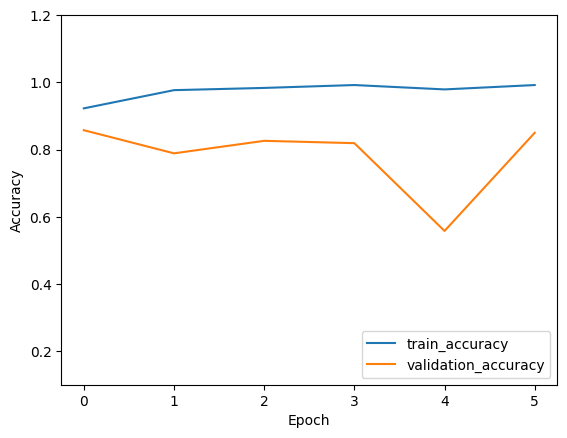

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.2])
plt.legend(loc='lower right')

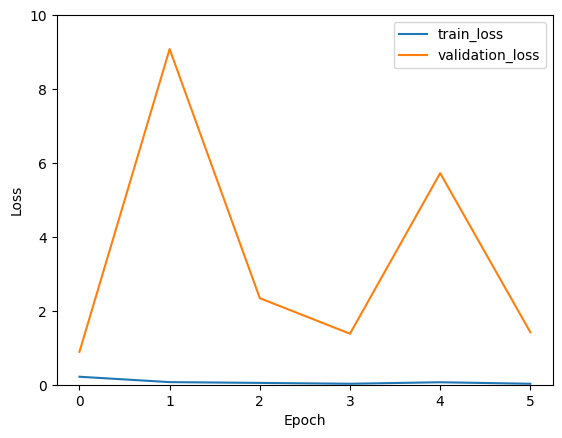

In [10]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 10])
plt.legend(loc='upper right')

1/1 [==============================] - 1s 1s/step


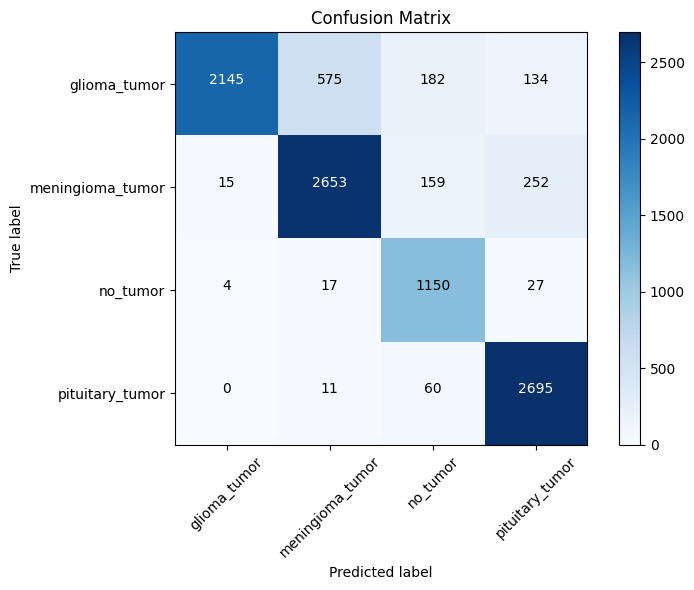

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Assuming you have already trained your model and have 'val_ds' for validation data

# Initialize empty lists for ground truth and predicted labels
y_true = []
y_pred = []

# Iterate through the validation dataset to collect labels
for x_batch, y_batch in val_ds:
    y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))  # Make predictions using your trained model

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']  # Replace with your class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add labels to each cell
thresh = confusion.max() / 2.0
for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
    plt.text(j, i, format(confusion[i, j], 'd'),
             horizontalalignment="center",
             color="white" if confusion[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [12]:
from sklearn.metrics import classification_report

# Assuming you have class_names defined as a list of class labels
class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

# Calculate the classification report with class names
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.71      0.82      3036
meningioma_tumor       0.81      0.86      0.84      3079
        no_tumor       0.74      0.96      0.84      1198
 pituitary_tumor       0.87      0.97      0.92      2766

        accuracy                           0.86     10079
       macro avg       0.85      0.88      0.85     10079
    weighted avg       0.87      0.86      0.86     10079

